# Plot figure 1

In [1]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re


#### Load the data

In [2]:
os.chdir('..')
home_dir = os.getcwd()
downloaded_data = r"downloaded-data"


In [3]:
with open(f"{downloaded_data}\\roads_continents_data_18-23_ai.json", "r") as f:
    data = json.load(f)
# data


#### Edit the obtained data into desired shape to create a DataFrame

In [4]:
d = {
    "feature": [],
    "source": [],
    "timestamp": [],
    "value": []
}


In [5]:
for cont in data:
    for dic1 in cont:
        feature, source = dic1["groupByObject"][0], dic1["groupByObject"][1]
        for res in dic1["result"]:
            d["feature"].append(feature)
            d["source"].append(source)
            d["timestamp"].append(res["timestamp"])
            d["value"].append(res["value"])

df = pd.DataFrame(d)
# df

In [6]:
# xtract only the year
df["year"] = pd.to_datetime(df["timestamp"]).dt.year

#### Append the names of the regions to the DataFrame

In [7]:

geojson_dir = os.path.join(home_dir, "geojson-continent-borders", "")

geojson_names = []
for (dir_path, dir_names, file_names) in os.walk(geojson_dir):  # give the path
    geojson_names.extend(file_names)
print(geojson_names)
print(os.getcwd())


['0_Africa.geojson', '1_Asia.geojson', '2_Australia.geojson', '3_North America.geojson', '4_Oceania.geojson', '5_South America.geojson', '6_Antarctica.geojson', '7_Europe.geojson']
c:\Users\milan\OneDrive - MUNI\VŠ\PhD\Zahraniční stáž\Work\HeiGIT_notebooks\analysis\ai-assisted-osm-mapping-stats


In [8]:
geojson_names_2 = geojson_names

id_name_dic = {int(re.search(r'^\d+', k)[0]): re.search(r'\_.+\.', v)[0][1:-1]
                for k, v in zip(geojson_names, geojson_names_2)}
id_name_ser = pd.Series(id_name_dic)
id_name_df = pd.DataFrame(id_name_ser, columns=["name"])
id_name_df = id_name_df.reset_index().rename(columns={"index": "id"})
id_name_df["id"] = id_name_df["id"].astype(int)
# id_name_df


In [9]:
# merge df with region names based on ids
df = df.merge(id_name_df, how="left", left_on="feature",
               right_on="id")

## Plot the results

#### Data preparation and filtering

In [10]:
# get the number of AI Microsoft (source=microsoft/BuildingFootprints) / manually mapped (remainder) buildings for every year
grouped = df.groupby(["source", "year"])["value"].sum()
# grouped

In [11]:
# merge the DataFrame with groupBy DataFrame and compute the percentage
merged_data = df.merge(grouped, on=["source", 'year'], how='left', )
merged_data = merged_data.rename(columns={"value_x":"length", "value_y":"total_len"})
merged_data["percentage"] = (
    merged_data["length"] / merged_data["total_len"]) * 100
# merged_data.head(10)


In [12]:
# percentage verification
merged_data.groupby(["source", "year"])["percentage"].sum()


source        year
remainder     2018    100.0
              2019    100.0
              2020    100.0
              2021    100.0
              2022    100.0
              2023    100.0
source=maxar  2018      0.0
              2019      0.0
              2020    100.0
              2021    100.0
              2022    100.0
              2023    100.0
Name: percentage, dtype: float64

In [13]:
# create the dataframe by the source
# buiildings used from Microsoft AI
df_ai = merged_data.loc[(df["source"] == "source=maxar"), :]
df_rem = merged_data.loc[(df["source"] == "remainder"),:] # remainder = manually mapped roads
# df_ai.head()


In [14]:
# how the DataFrame looks like – manually mapped roads
df_rem.head()



,feature,source,timestamp,length,year,id,name,total_len,percentage
0,0,remainder,2018-01-01T00:00:00Z,5.454454e+09,2018,0,Africa,5.037323e+10,10.828081
1,0,remainder,2019-01-01T00:00:00Z,6.470871e+09,2019,0,Africa,5.478630e+10,11.811113
2,0,remainder,2020-01-01T00:00:00Z,7.902788e+09,2020,0,Africa,5.952437e+10,13.276557
3,0,remainder,2021-01-01T00:00:00Z,8.821002e+09,2021,0,Africa,6.465945e+10,13.642247
4,0,remainder,2022-01-01T00:00:00Z,9.619285e+09,2022,0,Africa,6.819191e+10,14.106197


In [15]:
# how the DataFrames look like – AI Microsoft buildings
df_ai.head()

,feature,source,timestamp,length,year,id,name,total_len,percentage
6,0,source=maxar,2018-01-01T00:00:00Z,0.000000e+00,2018,0,Africa,0.000000e+00,NaN
7,0,source=maxar,2019-01-01T00:00:00Z,0.000000e+00,2019,0,Africa,0.000000e+00,NaN
8,0,source=maxar,2020-01-01T00:00:00Z,9.156849e+05,2020,0,Africa,1.430082e+06,64.030259
9,0,source=maxar,2021-01-01T00:00:00Z,4.286408e+07,2021,0,Africa,3.193565e+08,13.422016
10,0,source=maxar,2022-01-01T00:00:00Z,2.080913e+08,2022,0,Africa,1.415734e+09,14.698476


#### Plots

In [16]:
def fill_under_lines(*argv, alpha=.2, **kwargs):
    for ax in argv:
        if ax is None:
            ax = plt.gca()
        for line in ax.lines:
            x, y = line.get_xydata().T
            ax.fill_between(x, 0, y, color=line.get_color(), alpha=alpha, **kwargs)

Text(0, 0.5, 'Length of roads')

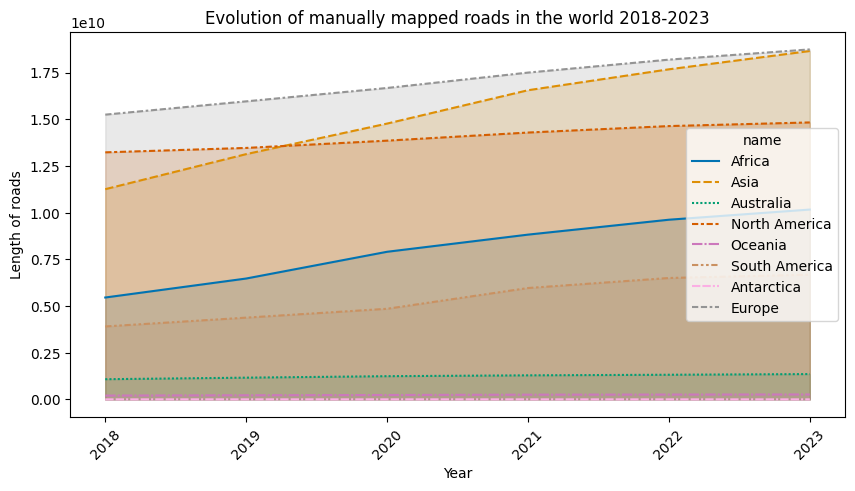

In [17]:
# without dictionary labels

plt.figure(figsize=(10, 5))
plt.title("Evolution of manually mapped roads in the world 2018-2023")

# plot the data
ax = sns.lineplot(x='year', y='length', hue='name', data=df_rem,
                  palette='colorblind',  style='name',
                  )
# log y axis
# plt.yscale("log")

# rotate x labels
plt.xticks(rotation=45)
# plt.ylim(top=105)

# fill the area under lines
fill_under_lines(ax)

# set x and y axis labels
plt.xlabel("Year")
plt.ylabel("Length of roads")


Text(0, 0.5, 'Length of roads')

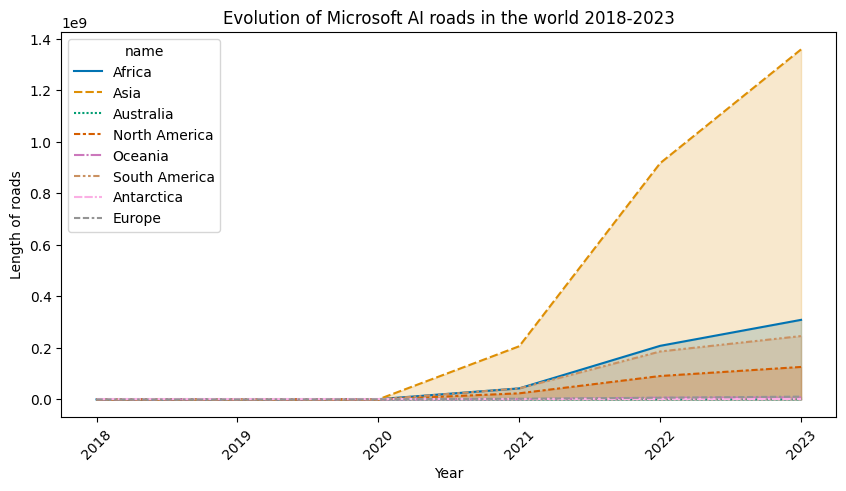

In [18]:
# without dictionary labels

plt.figure(figsize=(10, 5))
plt.title("Evolution of Microsoft AI roads in the world 2018-2023")

# plot the data
ax = sns.lineplot(x='year', y='length', hue='name', data=df_ai,
                  palette='colorblind',  style='name',
                  )
# log y axis
# plt.yscale("log")

# rotate x labels
plt.xticks(rotation=45)
# plt.ylim(top=105)

# fill the area under lines
fill_under_lines(ax)

# set x and y axis labels
plt.xlabel("Year")
plt.ylabel("Length of roads")


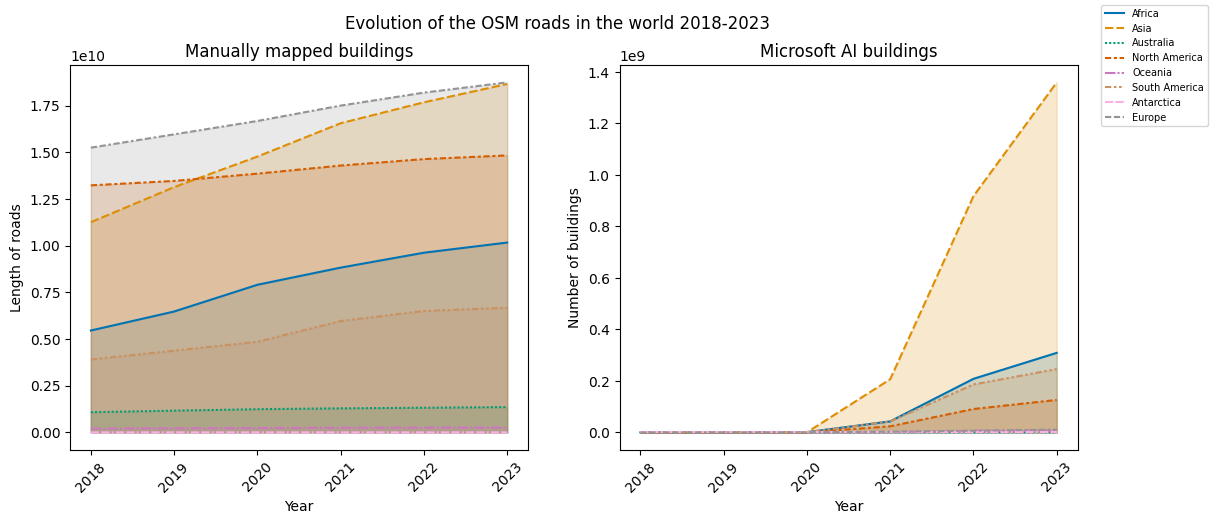

In [19]:
# create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(13, 5))
fig.suptitle("Evolution of the OSM roads in the world 2018-2023")

# create a Seaborn plot on the first subplot
sns.lineplot(x='year', y='length', hue='feature', data=df_rem, ax=ax1,
             palette='colorblind', style='feature',
             hue_order=id_name_dic.keys(),
             style_order=id_name_dic.keys())

# create another Seaborn plot on the second subplot
sns.lineplot(x='year', y='length', hue='feature', data=df_ai, ax=ax2,
             palette='colorblind', style='feature',
             hue_order=id_name_dic.keys(),
             style_order=id_name_dic.keys())

# set the legend labels
handles, _ = plt.gca().get_legend_handles_labels()
ax2.legend(handles, [id_name_dic[key]
           for key in id_name_dic.keys()], fontsize=7)
ax1.legend().remove()
ax2.legend().remove()

# ax1.set_yscale("log")
# ax2.set_yscale("log")

# set titles for each subplot
ax1.set_title("Manually mapped buildings")
ax2.set_title("Microsoft AI buildings")

# set the y axis limit
# ax1.set_ylim(top=105, bottom=-5)
# ax2.set_ylim(top=105, bottom=-5)

# set the y axis label
ax1.set_xlabel("Year")
ax1.set_ylabel("Length of roads")

# set the x axis label
ax2.set_xlabel("Year")
ax2.set_ylabel("Number of buildings")

# fill the area under lines
fill_under_lines(ax1, ax2)

# rotate x-axis labels for both subplots
for ax in [ax1, ax2]:
    # ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.tick_params(axis='x', labelrotation=45)

fig.legend(handles, [id_name_dic[key]
           for key in id_name_dic.keys()], fontsize=7)

plt.show()
